In [9]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/luca/GitRepositories/Brancher')

import chainer
import chainer.functions as F
import matplotlib.pyplot as plt
import numpy as np

from brancher.distributions import NormalDistribution, LogNormalDistribution
from brancher.variables import DeterministicVariable, RandomVariable, ProbabilisticModel
from brancher.standard_variables import NormalVariable, LogNormalVariable
from brancher import inference
import brancher.functions as BF

In [12]:
# Real model
nu_real = 1.
mu_real = -2.
x_real = NormalVariable(mu_real, nu_real, "x_real")

# Normal model
nu = LogNormalVariable(0., 1., "nu")
mu = NormalVariable(0., 10., "mu")
x = NormalVariable(mu, nu, "x")
model = ProbabilisticModel([x])

model

In [13]:
# Print samples
sample = model.get_sample(10)
sample

,0,1,2,3,4,5,6,7,8,9
nu_sigma,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325
nu_mu,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nu,0.663631,0.306245,0.211564,3.889006,1.754191,0.625998,2.789746,0.752901,0.768493,0.792269
mu_var,9.999954,9.999954,9.999954,9.999954,9.999954,9.999954,9.999954,9.999954,9.999954,9.999954
mu_mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mu,0.357152,2.886066,-2.537349,-1.561020,-3.023512,0.249586,4.483177,-1.722962,-2.554280,4.597054
x,-0.498774,4.158768,-2.635190,-0.968566,-3.455817,0.063446,3.523137,-2.727329,-2.750320,4.511770


In [14]:
# Print samples from single variable
x_sample = x.get_sample(10)
x_sample

,0,1,2,3,4,5,6,7,8,9
x,0.913674,5.163704,-1.853071,-3.849795,-1.260286,-2.320473,-1.232024,-7.424215,-3.316829,-1.444635


In [16]:
# Print samples conditional on an input
in_sample = model.get_sample(10, input_values={mu: 100.})
in_sample

,0,1,2,3,4,5,6,7,8,9
nu_sigma,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325,0.541325
nu_mu,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nu,0.220775,1.404169,1.869962,4.074393,1.305014,0.106153,4.307888,0.320310,1.921255,1.061765
mu,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
x,99.776810,101.103088,97.880844,96.461189,97.934128,99.386581,101.488831,101.060150,101.547623,101.283585


In [17]:
# # Generate data
data = x_real._get_sample(number_samples=50)

# Observe data
x.observe(data[x_real][:, 0, :])
model.model_summary

,Distribution,Parents,Observed
nu_sigma,Deterministic,(),False
nu_mu,Deterministic,(),False
nu,Log Normal,"{nu_sigma, nu_mu}",False
mu_var,Deterministic,(),False
mu_mean,Deterministic,(),False
mu,Normal,"{mu_var, mu_mean}",False
x,Normal,"{nu, mu}",True


In [18]:
# Variational model
Qnu = LogNormalVariable(0., 1., "nu", learnable=True)
Qmu = NormalVariable(0., 1., "mu", learnable=True)
model.set_posterior_model(ProbabilisticModel([Qmu, Qnu]))

# Inference
inference.stochastic_variational_inference(model,
                                           number_iterations=100,
                                           number_samples=50,
                                           optimizer=chainer.optimizers.Adam(0.1))
loss_list = model.diagnostics["loss curve"]

100%|██████████| 100/100 [00:01<00:00, 52.24it/s]


In [24]:
# print posterior sample
post_samples = model.get_posterior_sample(1000)
post_samples

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
nu,1.155160,1.045446,1.572621,1.135419,0.735420,1.250895,1.120772,1.315099,1.464696,0.781534,...,1.587984,1.534244,1.799852,0.946717,1.080675,1.364579,2.281535,1.333793,1.033459,0.728249
mu,-1.963700,-1.635073,-1.529707,-1.700004,-1.710953,-1.905733,-1.720294,-2.098331,-1.908400,-1.763471,...,-1.789321,-2.347422,-1.609271,-2.132768,-2.343912,-2.050511,-1.652724,-1.526896,-1.647584,-1.810932
x,-3.206246,-3.023894,-1.399378,-3.323322,-2.588661,-1.165328,-2.097088,-2.402976,-1.479962,-2.213020,...,-1.671049,-1.862075,0.093468,-2.323399,-2.146243,0.820893,-2.726095,-2.127037,-2.391030,-1.455664
mu_var,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,...,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236,-2.782236
mu_mean,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,...,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847,-1.744847
nu_sigma,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,...,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940,-1.069940
nu_mu,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,...,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698,0.205698


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde344cba90>,
      dtype=object)

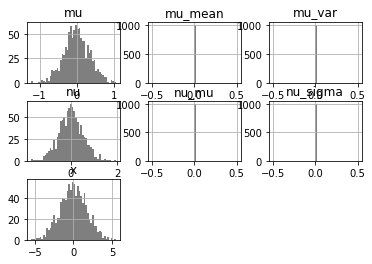

In [27]:
import seaborn as sns

post_samples.transpose().diff().hist(color='k', alpha=0.5, bins=50)